In [2]:
import struct
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
 
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from preprocessing.data_utils import get_ETL8B_data

In [219]:
W, H = 64, 64
new_img = Image.new('1', (W, H))

id_category = 0
dataset = 1
filename = '../ETLC/ETL8B/ETL8B2C'+str(dataset)

X = []
Y = []
with open(filename, 'r') as f:
    f.seek((id_category * 160 + 1) * 512)
    for i in range(160):
        try:
            r = read_record_ETL8B2(f)
            new_img.paste(r[-1], (0,0))    
            iI = Image.eval(new_img, lambda x: not x)

            X.append(np.asarray(new_img.getdata()).reshape(W,H))
            Y.append(r[1])
        except:
            break

In [224]:
new_img.thumbnail((32,32), Image.ANTIALIAS)
new_img
np.asarray(new_img.getdata()).reshape(32,32)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

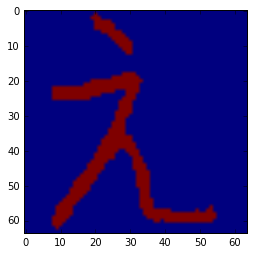

In [367]:
# 1+51200 records
# 320 categories
# 160 writers per category
# X_small, Y_small = get_ETL8B_data(1, 10, 20, resize=(32,32))
X_small, Y_small = get_ETL8B_data(1, range(0,75), 1)
imshow(X_small[3])

In [3]:
from sklearn import datasets, metrics, cross_validation
import skflow
import tensorflow as tf

In [10]:
# Load dataset.
# Hiragana data set with subset of writers
characters, labels = get_ETL8B_data(1, range(0,75), 30, vectorize=True, resize=(28,28))

# rename labels from 0 to n_labels-1
unique_labels = list(set(labels))
labels_dict = {unique_labels[i]:i for i in range(len(unique_labels))}
new_labels = np.array([labels_dict[l] for l in labels], dtype=np.int32)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(characters,
                                                                     new_labels,
                                                                     test_size=0.3,
                                                                     random_state=42)

In [11]:
# confirm data type and shapes
print type(X_train[0,0]), type(y_train[0])
print X_train.shape, y_train.shape

<type 'numpy.int32'> <type 'numpy.int32'>
(1575, 784) (1575,)


In [12]:
# Start with a DNN and try to overfit
n_classes = len(set(labels))
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[500,500,500],
                                            n_classes=n_classes,
                                            steps=5000)

# Fit and predict.
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_train)
score = metrics.accuracy_score(y_train, y_pred)
print('Accuracy: {0:f}'.format(score))

Step #1, avg. loss: 80.13940
Step #501, epoch #10, avg. loss: 4.07014
Step #1001, epoch #20, avg. loss: 0.86775
Step #1501, epoch #30, avg. loss: 0.67417
Step #2001, epoch #40, avg. loss: 0.59842
Step #2501, epoch #50, avg. loss: 0.56344
Step #3001, epoch #60, avg. loss: 0.52626
Step #3501, epoch #70, avg. loss: 0.51225
Step #4001, epoch #80, avg. loss: 0.43648
Step #4501, epoch #90, avg. loss: 0.43179
Accuracy: 0.970794


In [13]:
y_pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {0:f}'.format(score))

Accuracy: 0.303704


In [11]:
def max_pool_2x2(tensor_in):
    return tf.nn.max_pool(tensor_in,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

def conv_model(X, y):
    # reshape X to 4d tensor with 2nd and 3rd dimensions being image width and height
    # final dimension being the number of color channels
    X = tf.reshape(X, [-1, 28, 28, 1])
    # first conv layer will compute 32 features for each 5x5 patch
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=32, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x2(h_conv1)
    # second conv layer will compute 64 features for each 5x5 patch
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x2(h_conv2)
        # reshape tensor into a batch of vectors
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    # densely connected layer with 1024 neurons
    h_fc1 = skflow.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, keep_prob=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

In [13]:
# Training and predicting
n_classes = len(set(labels))
classifier = skflow.TensorFlowEstimator(model_fn=conv_model,
                                        n_classes=n_classes,
                                        batch_size=100,
                                        steps=200,
                                        learning_rate=0.001)
# Fit and predict.
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {0:f}'.format(score))

Step #1, avg. loss: 205.85765
Step #21, epoch #1, avg. loss: 196.51471
Step #41, epoch #3, avg. loss: 151.45715
Step #61, epoch #5, avg. loss: 123.10767
Step #81, epoch #7, avg. loss: 101.42400
Step #101, epoch #9, avg. loss: 82.23667
Step #121, epoch #11, avg. loss: 68.80660
Step #141, epoch #12, avg. loss: 60.12611
Step #161, epoch #14, avg. loss: 51.49200
Step #181, epoch #16, avg. loss: 45.77184
Accuracy: 0.028889
